# day24: Intro to MovieLens100k Dataset and Recommendation


# Prerequisites

Download the dataset and starter code associated with Project C:

* Dataset CSV files: https://github.com/tufts-ml-courses/cs135-25s-assignments/tree/main/projectB/data_movie_lens_100k

* Starter code files: https://github.com/tufts-ml-courses/cs135-25s-assignments/tree/master/projectB/

# Objectives

We will practice:

* Understanding the MovieLens 100k dataset
* Getting a head start on Project B problem 1
* Understanding the surprise Python package

# Outline

* [Part 1: Exploration of the dataset](#part1)
* [Part 2: Using the provided starter code for Problem 1](#part2)
* [Part 3: Using surprise for implementing latent matrix factorization models](#part3)
* [Part 4: Visualizing latent factors in 2D](#part4)


# Takeaways

* Start early on Project B!
* Think carefully things like early stopping when you do SGD

In [1]:
# Import numpy
import numpy as np

# Import pandas for data handling
import pandas as pd

In [2]:
import os

In [8]:
# Import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Import starter code

In [29]:
from train_valid_test_loader import load_train_valid_test_datasets

In [30]:
DATA_PATH = 'data_movie_lens_100k/' # TODO fixme: Path to where dataset csv files live on your system
if not os.path.exists(os.path.join(DATA_PATH, 'select_movies.csv')):
    try:
        DATA_PATH = os.path.join(os.environ.get("HOME", ""),
                    'courses/cs135-25s-staffonly/proj_src/projB/data_movie_lens_100k/')
        assert os.path.exists(os.path.join(DATA_PATH, 'select_movies.csv'))
    except AssertionError:
        print("Please store path to movie_lens_100k dataset in DATA_PATH")

assert os.path.exists(os.path.join(DATA_PATH, 'select_movies.csv'))

# Part 1: Exploring the Movie Lens 100k dataset

### How to import the dataset

```
Usage
-----
>>> train, valid, test, n_users, n_items = load_train_valid_test_datasets(
...     data_path='/path/to/data_movie_lens_100k/')
>>> n_users
943
>>> n_items
1682
>>> type(train)
tuple
>>> len(train)
3
```

In [31]:
train_tuple, test_tuple, valid_tuple, n_users, n_items = load_train_valid_test_datasets(data_path=DATA_PATH)

In [32]:
type(train_tuple)

tuple

In [33]:
len(train_tuple)

3

In [34]:
n_users

943

In [35]:
n_items

1682

In [36]:
n_train = len(train_tuple[0])
n_valid = len(valid_tuple[0])
n_test = len(test_tuple[0])

print("n_train", f"{n_train}")
print("n_valid", f"{n_valid}")
print("n_test", f"{n_test}")

n_train 70000
n_valid 10000
n_test 9992


### Structure of the dataset

Each dataset *split* (train or valid or test) is represented as a *tuple* of 3 values:

* a 1D array of user_ids
* a 1D array of item_ids
* a 1D array of ratings


In [37]:
n_train_examples = len(train_tuple[0])
N = n_train_examples

# Unpack the tuple into its three contained arrays
userids_tr_N = train_tuple[0]
itemids_tr_N = train_tuple[1]
ratings_tr_N = train_tuple[2]

### Print first 5 values in each array

We should see that:

* user 662 gave movie 761 a 5
* user 298 gave movie 90 a 4
* user 90 gave movie 349 a 4
* user 912 gave movie 917 a 4
* user 302 gave movie 42 a 3

In [ ]:
print(userids_tr_N[:5])
print(itemids_tr_N[:5])
print(ratings_tr_N[:5])

[662 298  90 912 302]
[761  90 349 917  42]
[5 4 4 4 3]


### Exercise 1a: What is the *average* rating (on the 5 star scale) for each split (train/valid/test)?

TODO write code

### Load info about each movie

In [ ]:
movie_df = pd.read_csv(os.path.join(DATA_PATH, 'movie_info.csv'))

In [ ]:
movie_df.shape

(1681, 4)

In [ ]:
movie_df.head()

,item_id,title,release_year,orig_item_id
0,0,Toy Story (1995),1995,1
1,1,GoldenEye (1995),1995,2
2,2,Four Rooms (1995),1995,3
3,3,Get Shorty (1995),1995,4
4,4,Copycat (1995),1995,5


In [ ]:
movie_df.tail()

,item_id,title,release_year,orig_item_id
1676,1676,Mat' i syn (1997),1998,1678
1677,1677,B. Monkey (1998),1998,1679
1678,1678,Sliding Doors (1998),1998,1680
1679,1679,You So Crazy (1994),1994,1681
1680,1680,Scream of Stone (Schrei aus Stein) (1991),1996,1682


### Worked Example 1c: How many movies are *never* rated in the training set? What are they?

In [ ]:
M = n_items

In [ ]:
count_per_movie_M = np.zeros(M)

# Loop over all movie ids, count how often they appear in dataset
for m in range(M):
    count_per_movie_M[m] = np.sum(itemids_tr_N == m)

In [ ]:
zero_count_movie_ids = np.flatnonzero(count_per_movie_M == 0)

In [ ]:
zero_count_movie_ids

array([ 709,  850, 1233, 1288, 1307, 1308, 1318, 1321, 1327, 1329, 1340,
       1341, 1350, 1372, 1450, 1459, 1484, 1505, 1508, 1513, 1517, 1541,
       1549, 1559, 1561, 1562, 1568, 1572, 1574, 1576, 1582, 1584, 1594,
       1599, 1601, 1604, 1609, 1612, 1616, 1617, 1630, 1632, 1635, 1644,
       1645, 1646, 1649, 1652, 1653, 1664, 1673, 1674, 1675, 1677, 1680,
       1681])

In [ ]:
len(zero_count_movie_ids)

56

In [ ]:
movie_df.loc[zero_count_movie_ids[:10]].head(5) # First 5 movies that were never rated in training set

,item_id,title,release_year,orig_item_id
709,709,"Substance of Fire, The (1996)",1996,711
850,850,"Bloody Child, The (1996)",1996,852
1233,1233,"Big Bang Theory, The (1994)",1994,1235
1288,1288,Country Life (1994),1994,1290
1307,1307,"Very Natural Thing, A (1974)",1974,1309


### Exercise 1d: Which movie occurs *most often* in the training set?

TODO write code to solve

### Exercise 1e: What is the average (mean) rating of Toy Story in the training set?

TODO write code to solve

### Load info about each user

In [ ]:
user_df = pd.read_csv(os.path.join(DATA_PATH, 'user_info.csv'))

In [ ]:
user_df.shape

(943, 4)

In [ ]:
n_users

943

Print first 5 rows of the user id Data Frame

In [ ]:
user_df.head()

,user_id,age,is_male,orig_user_id
0,0,24,1,1
1,1,53,0,2
2,2,23,1,3
3,3,24,1,4
4,4,33,0,5


### Exercise 1f: What is the average age of the users in our dataset?

TODO solve code to do this

### Load info about select handful of movies

In [ ]:
select_movies_df = pd.read_csv(os.path.join(DATA_PATH, 'select_movies.csv'))

In [ ]:
select_movies_df

,item_id,title,release_year,orig_item_id
0,0,Toy Story (1995),1995,1
1,70,"Lion King, The (1994)",1994,71
2,98,Snow White and the Seven Dwarfs (1937),1937,99
3,131,"Wizard of Oz, The (1939)",1939,132
4,142,"Sound of Music, The (1965)",1965,143
5,49,Star Wars (1977),1977,50
6,171,"Empire Strikes Back, The (1980)",1980,172
7,180,Return of the Jedi (1983),1997,181
8,81,Jurassic Park (1993),1993,82
9,251,"Lost World: Jurassic Park, The (1997)",1997,252


# Part 2: Head start on Project C Problem 1

### Discussion 2a: Do you understand what Problem 1 is asking you to do? Work with your group to understand it.

Go read the prompt for Problem 1 (if you haven't already)

Link: https://www.cs.tufts.edu/cs/135/2025s/projectB.html#problem1

### Discussion 2b: Do you understand how the starter code works?

Go read through the CollabFilterOneVectorPerItem class


This class defines 3 key methods:

* `init_parameter_dict` Mostly provided, just need minor modifications for dimensionality
* `predict` You will complete this
* `calc_loss_wrt_parameter_dict` You will complete this

It inherits 2 other key methods from AbstractBaseClassSGD, which you do NOT need to change:

* `__init__` the constructor
* `fit` : which fits the model to provided dataset via SGD



### Import the starter code from problem 1

In [ ]:
from CollabFilterOneVectorPerItem import CollabFilterOneVectorPerItem

### Create an instance of latent factor (LF) model

In [ ]:
# Create the model
model = CollabFilterOneVectorPerItem(
    n_epochs=6, batch_size=10000, step_size=0.1, n_factors=2)

In [ ]:
# We only just constructed this model
# We don't yet have initialized parameters yet
hasattr(model, 'param_dict')

False

### Initialize the parameters

In [ ]:
model.init_parameter_dict(n_users, n_items, train_tuple)

In [ ]:
hasattr(model, 'param_dict')

True

In [ ]:
model.param_dict      # in starter code, the dimensionality of U/V is not right.... you need to fix that

{'mu': array([1.]),
 'b_per_user': array([1.]),
 'c_per_item': array([1.]),
 'U': array([-0.00061335]),
 'V': array([0.00087656])}

### Call fit to run SGD training

We are intentionally calling this with out-of-the-box starter code.

It should just show several steps of SGD that do not change the parameters

We *expect* this will yield the warning "Output seems independent of input.", because the loss function is set to zero always in the starter code. If you fix the loss, this warning will go away.

In [ ]:
model.fit(train_tuple, valid_tuple)

epoch       0.000 | loss_total     0.00000 | tr RMSE     2.76970 | va RMSE     2.74794 | grad_wrt_mu     0.00000 | grad_wrt_b_per_user     0.00000 | grad_wrt_c_per_item     0.00000 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.143 | loss_total     0.00000 | tr RMSE     2.76970 | va RMSE     2.74794 | grad_wrt_mu     0.00000 | grad_wrt_b_per_user     0.00000 | grad_wrt_c_per_item     0.00000 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.286 | loss_total     0.00000 | tr RMSE     2.76970 | va RMSE     2.74794 | grad_wrt_mu     0.00000 | grad_wrt_b_per_user     0.00000 | grad_wrt_c_per_item     0.00000 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.429 | loss_total     0.00000 | tr RMSE     2.76970 | va RMSE     2.74794 | grad_wrt_mu     0.00000 | grad_wrt_b_per_user     0.00000 | grad_wrt_c_per_item     0.00000 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.571 | loss_total     0.00000 | tr RMSE     2.76970 | va RMSE  

/Users/mhughes/micromamba/envs/cs135_25s_env/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


After calling `fit`, we have access to many useful attributes that help us track the history of the SGD

These include:

* trace_epoch
* trace_rmse_train
* trace_rmse_valid

... and many more!

In [ ]:
# Here we show at which epochs we collected a snapshot of model performance

model.trace_epoch

[0.0,
 0.14285714285714285,
 0.2857142857142857,
 0.42857142857142855,
 0.5714285714285714,
 0.7142857142857142,
 0.857142857142857,
 1.0,
 1.1428571428571428,
 1.2857142857142856,
 1.4285714285714284,
 1.5714285714285712,
 1.714285714285714,
 1.8571428571428568,
 2.0,
 2.571428571428571,
 3.0,
 3.571428571428571,
 4.0,
 4.571428571428573,
 5.0,
 5.571428571428573,
 5.857142857142859]

In [ ]:
# Here we show what the recorded MAE on the training set was at each epoch

model.trace_rmse_train

[2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171,
 2.769700860588171]

### Example code for a trace plot of error vs epoch

Starter code should produce a flat line (since its loss is wrong).

Your goal is to implement the loss correctly. When you do, you should see *improvement* in the MAE as you train for many epochs.

(0.0, 3.0)

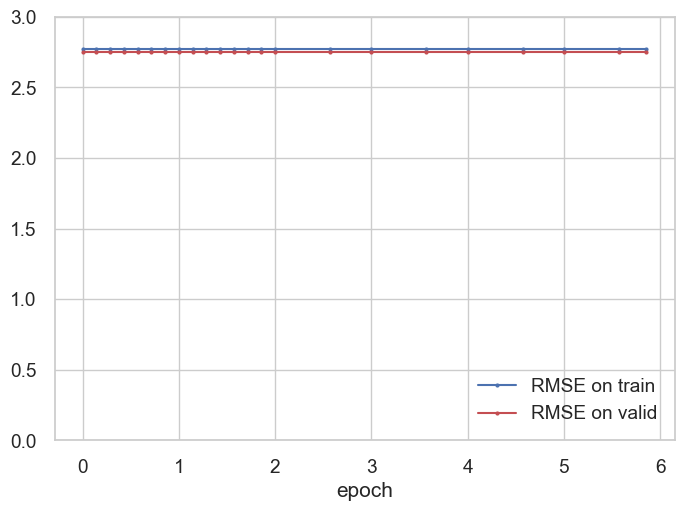

In [ ]:
plt.plot(model.trace_epoch, model.trace_rmse_train, 'b.-', label='RMSE on train')
plt.plot(model.trace_epoch, model.trace_rmse_valid, 'r.-', label='RMSE on valid')

plt.xlabel('epoch');
plt.legend(loc='lower right');
plt.ylim([0, 3])

### Discussion 2c: Do you understand what happens under the hood when you call `fit`?

Go read through the provided `fit` method

Link: https://github.com/tufts-ml-courses/cs135-25s-assignments/blob/main/projectB/AbstractBaseCollabFilterSGD.py#L107

You do not need to EDIT this at all, you can use it out of the box. The hard work of SGD implementation has been done for you.

We just want you to understand conceptually how it works.

In particular, you should focus your reading on these bits of code:

* [Line 179](https://github.com/tufts-ml-courses/cs135-25s-assignments/blob/main/projectB/AbstractBaseCollabFilterSGD.py#L179) is where we loop over epochs
* [Line 183](https://github.com/tufts-ml-courses/cs135-25s-assignments/blob/main/projectB/AbstractBaseCollabFilterSGD.py#183) is where we loop over each minibatches for the current epoch
* [Line 190](https://github.com/tufts-ml-courses/cs135-25s-assignments/blob/main/projectB/AbstractBaseCollabFilterSGD.py#L190) is where we compute the loss and gradient for the current minibatch
* [Line 248](https://github.com/tufts-ml-courses/cs135-25s-assignments/blob/main/projectB/AbstractBaseCollabFilterSGD.py#L248) is where we update the current parameters by taking a small step in the direction of the gradient



### Discussion 2d: Where in the `fit` code do you see autograd at work?


Hint: In Line 190 we call a function named `calc_loss_and_grad_wrt_parameter_dict`

Go see that function in Line 81:

https://github.com/tufts-ml-courses/cs135-25s-assignments/blob/main/projectB/AbstractBaseCollabFilterSGD.py#L81

This function calls `autograd.value_and_grad`, which will, given a function f, compute for a given input x *both* of:

* the value of the function at x: $f(x)$
* the gradient of the function at: $g(x)$

<a name="part3"></a>

# Part 3: Using the surprise library

Surprise is a Python library built to make recommendation systems

You can use it for *Problem 4* (our Open ended prediction challenge)

Here we give a very brief demo of how to use surprise on our data

### Check out its documentation here:

https://surprise.readthedocs.io/en/stable/index.html

### Import surprise library

If this breaks, you need to follow install instructions here: 
https://www.cs.tufts.edu/comp/135/2020f/projectC.html#code

In [ ]:
import surprise

Create a specialized Reader object for surprise to read the dataset

In [ ]:
reader = surprise.Reader(
    line_format='user item rating', sep=',',
    rating_scale=(1, 5), skip_lines=1)

### Load the entire development set into surprise's format

In [ ]:
dev_set = surprise.Dataset.load_from_file(
    os.path.join(DATA_PATH, 'ratings_all_development_set.csv'), reader=reader)

In [ ]:
dev_set_for_fit = dev_set.build_full_trainset()

In [ ]:
dev_set_for_predict = dev_set_for_fit.build_testset()

In [ ]:
dev_set_for_fit.global_mean

3.529480398257623

In [ ]:
dev_set_for_fit.rating_scale

(1, 5)

### Fit a latent factor model

See the surprise.SVD documentation: 

https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [ ]:
# Fit SVD model, which is like our LF
# One difference from our LF is the regularization is slightly different
# both per-item and per-users bias parameters are penalized

model = surprise.SVD(n_factors=2, n_epochs=10, lr_all=0.01, random_state=0)
model.fit(dev_set_for_fit)

<surprise.prediction_algorithms.matrix_factorization.SVD>

### Make predictions on development set (attempt 1)

Weirdly, surprise doesn't let you use the same dataset representation to do fit and do predict

We *expect* this line to fail

In [ ]:
try:
    model.test(dev_set_for_fit)
except TypeError as e:
    print(str(e))

'Trainset' object is not iterable


### Make predictions on the development set (attempt 2)

This is the proper way to ask for predictions

In [ ]:
yhat = model.test(dev_set_for_predict)

yhat[:3]

[Prediction(uid='772', iid='36', r_ui=3.0, est=2.7544139699224877, details={'was_impossible': False}),
 Prediction(uid='772', iid='175', r_ui=4.0, est=3.6351699413391376, details={'was_impossible': False}),
 Prediction(uid='772', iid='1168', r_ui=3.0, est=2.864122198932828, details={'was_impossible': False})]

<a id="part4"></a>

## Visualizing latent factors in 2D for select movies

We'll use the model we just trained via surprise above in Part 3.

Remember, we got a vector of size 2 for each movie


In [ ]:

print("shape of V (per item vectors): ")
print(model.qi.shape)


shape of V (per item vectors): 
(1662, 2)


In [ ]:
item_ids = []
for iid in model.trainset.all_items():
    item_ids.append(int(model.trainset.to_raw_iid(iid)))
item_ids = np.asarray(item_ids)

In [ ]:
item_ids.min()

0

In [ ]:
item_ids.max()

1680

In [ ]:
len(item_ids)

1662

Remember what our "select movies" are

In [ ]:
select_movies_df

,item_id,title,release_year,orig_item_id
0,0,Toy Story (1995),1995,1
1,70,"Lion King, The (1994)",1994,71
2,98,Snow White and the Seven Dwarfs (1937),1937,99
3,131,"Wizard of Oz, The (1939)",1939,132
4,142,"Sound of Music, The (1965)",1965,143
5,49,Star Wars (1977),1977,50
6,171,"Empire Strikes Back, The (1980)",1980,172
7,180,Return of the Jedi (1983),1997,181
8,81,Jurassic Park (1993),1993,82
9,251,"Lost World: Jurassic Park, The (1997)",1997,252


### Create figure of per-movie embeddings in 2D space

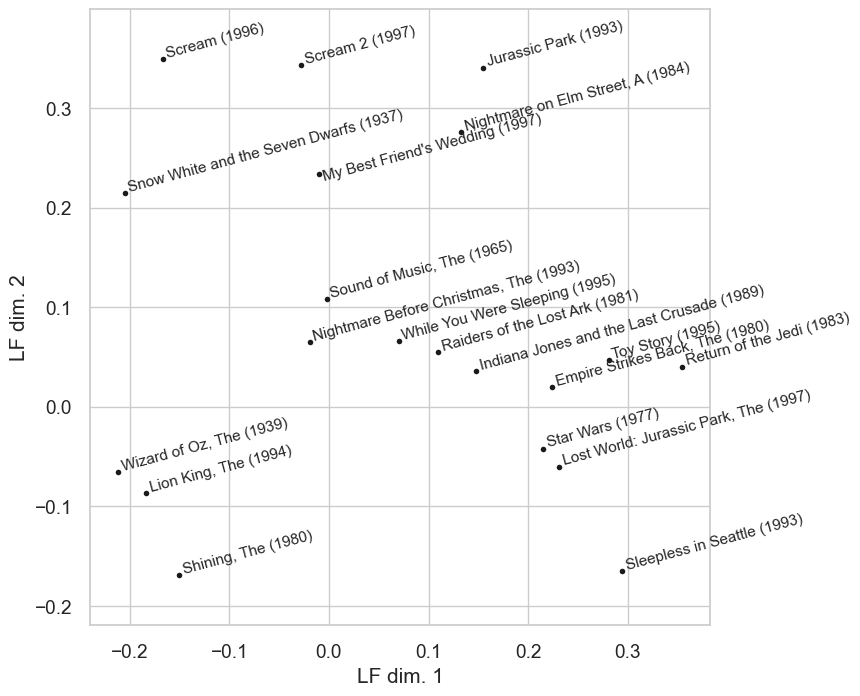

In [ ]:
B = 0.002

_, _ = plt.subplots(figsize=(8., 8.));

for sid, itemid in enumerate(select_movies_df['item_id'].values):
    title = select_movies_df['title'].values[sid]
    row_id = np.flatnonzero(item_ids == itemid)[0]
    movie_vec_2 = model.qi[row_id,:]
    plt.plot(movie_vec_2[0], movie_vec_2[1], 'k.', markersize=8)
    
    if title.count("Wedding"):
        curBy = -3 * B # manual edit to make more readable
    else:
        curBy = B
    
    plt.text(movie_vec_2[0] + B, movie_vec_2[1] + curBy,
             title, rotation=15, fontsize=11)
    
plt.xlabel('LF dim. 1');
plt.ylabel('LF dim. 2');    
plt.axis('equal');